In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing

warnings.filterwarnings("ignore")

# Preprocessing

In [2]:
df = pd.read_csv("pengeluaran.csv")
df.head()

,id_pengeluaran,id_user,kategori,jumlah,tanggal
0,1,1,Makanan dan Minuman,10000,1/4/2024
1,2,1,Makanan dan Minuman,12000,1/4/2024
2,3,1,Paket Internet,50000,1/4/2024
3,4,1,Kos,500000,1/4/2024
4,5,1,Makanan dan Minuman,15000,2/4/2024


In [3]:
df['kategori'].value_counts()

kategori
Makanan dan Minuman    458
Lainnya                 71
Transportasi            48
Kebutuhan Akademik      21
Paket Internet          13
Kos                     13
Kesehatan                5
Name: count, dtype: int64

In [4]:
# Ubah kolom 'tanggal' menjadi datetime
df['tanggal'] = pd.to_datetime(df['tanggal'], dayfirst=True)

# Tambahkan kolom 'bulan' untuk agregasi bulanan
df['bulan'] = df['tanggal'].dt.to_period('M')

monthly_expenses = df.groupby(['bulan', 'kategori'])['jumlah'].sum().reset_index()

# Ubah kolom 'bulan' ke format datetime
monthly_expenses['bulan'] = monthly_expenses['bulan'].dt.to_timestamp()

monthly_expenses = monthly_expenses.pivot(index='bulan', columns='kategori', values='jumlah')
monthly_expenses

kategori,Kebutuhan Akademik,Kesehatan,Kos,Lainnya,Makanan dan Minuman,Paket Internet,Transportasi
bulan,,,,,,,
2024-04-01,NaN,NaN,500000.0,90000.0,578000.0,50000.0,67000.0
2024-05-01,39000.0,15000.0,500000.0,80000.0,560000.0,50000.0,55000.0
2024-06-01,15000.0,NaN,500000.0,65000.0,553000.0,50000.0,50000.0
2024-07-01,36000.0,20000.0,500000.0,75000.0,516000.0,50000.0,55000.0
2024-08-01,5000.0,NaN,500000.0,92000.0,499000.0,50000.0,90000.0
2024-09-01,39000.0,NaN,500000.0,115000.0,539000.0,50000.0,20000.0
2024-10-01,5000.0,10000.0,500000.0,95000.0,547000.0,50000.0,15000.0
2024-11-01,45000.0,NaN,500000.0,80000.0,498000.0,50000.0,75000.0
2024-12-01,5000.0,50000.0,500000.0,130000.0,514000.0,50000.0,15000.0


In [5]:
monthly_expenses.describe()

kategori,Kebutuhan Akademik,Kesehatan,Kos,Lainnya,Makanan dan Minuman,Paket Internet,Transportasi
count,12.000000,5.00000,13.0,13.000000,13.000000,13.0,13.000000
mean,20666.666667,29000.00000,500000.0,97230.769231,530923.076923,50000.0,45384.615385
std,15610.796575,19493.58869,0.0,26686.931403,29862.076112,0.0,23257.753050
min,5000.000000,10000.00000,500000.0,57000.000000,476000.000000,50000.0,15000.000000
25%,5000.000000,15000.00000,500000.0,80000.000000,514000.000000,50000.0,30000.000000
50%,16000.000000,20000.00000,500000.0,92000.000000,536000.000000,50000.0,48000.000000
75%,36750.000000,50000.00000,500000.0,115000.000000,553000.000000,50000.0,55000.000000
max,45000.000000,50000.00000,500000.0,142000.000000,578000.000000,50000.0,90000.000000


In [6]:
monthly_expenses.duplicated().sum()

0

In [7]:
monthly_expenses.isnull().sum()

kategori
Kebutuhan Akademik     1
Kesehatan              8
Kos                    0
Lainnya                0
Makanan dan Minuman    0
Paket Internet         0
Transportasi           0
dtype: int64

In [8]:
monthly_expenses = monthly_expenses.fillna(0)
monthly_expenses.isnull().sum()

kategori
Kebutuhan Akademik     0
Kesehatan              0
Kos                    0
Lainnya                0
Makanan dan Minuman    0
Paket Internet         0
Transportasi           0
dtype: int64

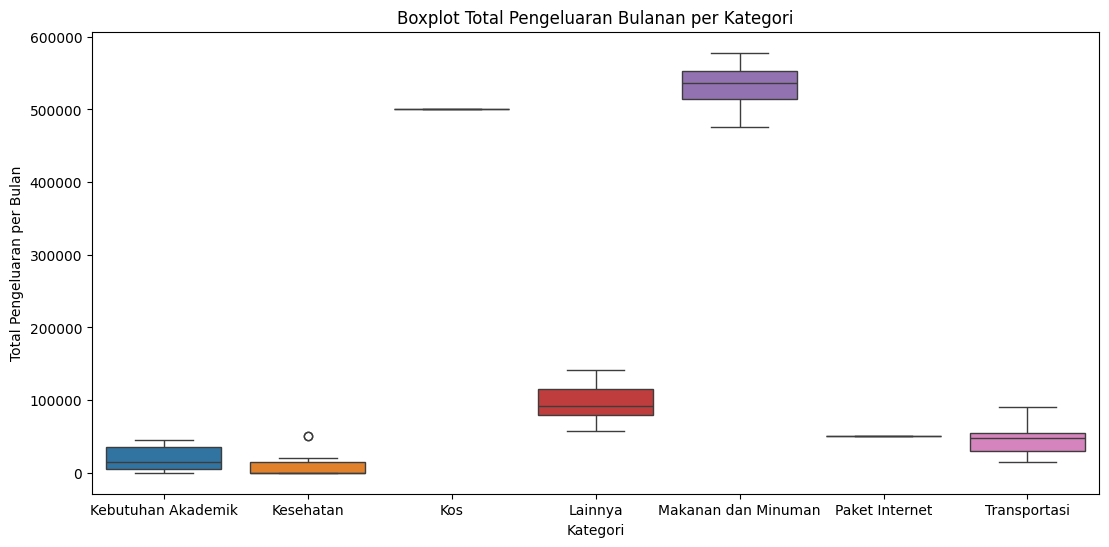

In [9]:
# Boxplot perkategori perbulan
plt.figure(figsize=(13, 6))
sns.boxplot(data=monthly_expenses)
plt.title('Boxplot Total Pengeluaran Bulanan per Kategori')
plt.xlabel('Kategori')
plt.ylabel('Total Pengeluaran per Bulan')
plt.show()

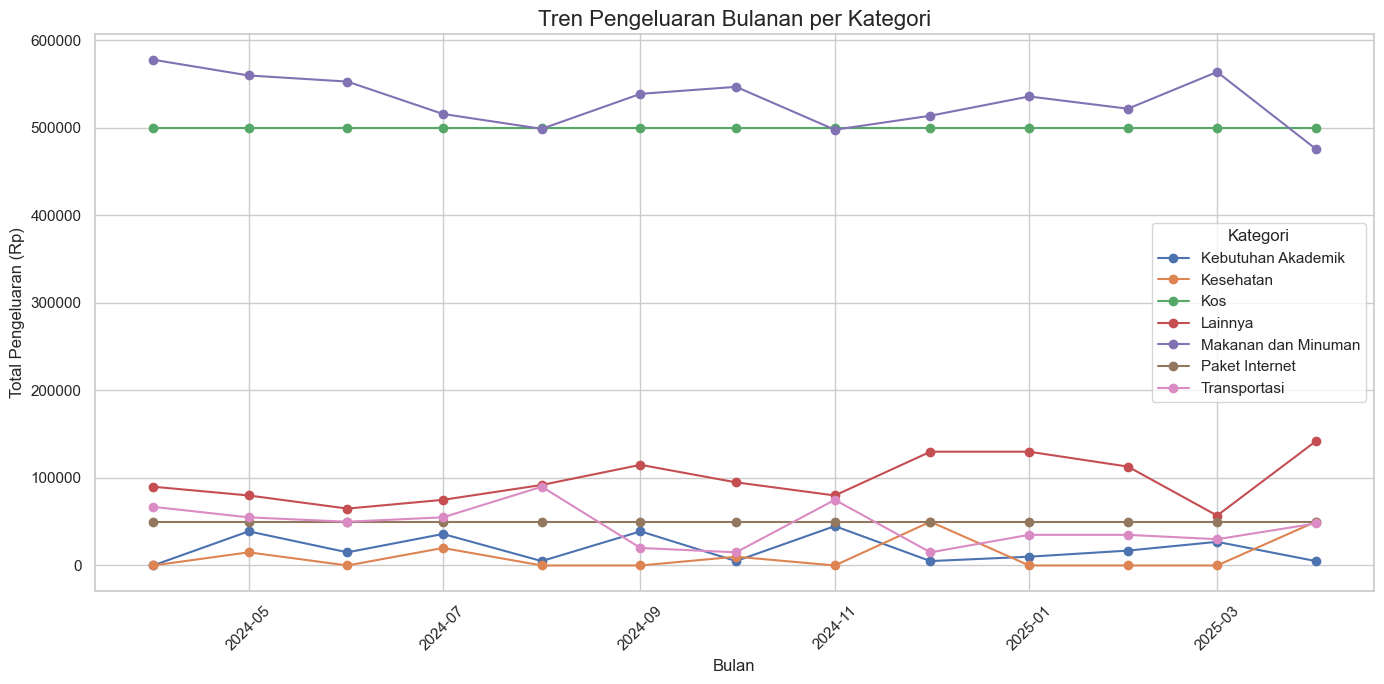

In [10]:
sns.set(style="whitegrid")
plt.figure(figsize=(14, 7))

# Plot tren pengeluaran untuk setiap kategori
for kategori in monthly_expenses.columns:
    plt.plot(monthly_expenses.index, monthly_expenses[kategori], marker='o', label=kategori)

plt.title('Tren Pengeluaran Bulanan per Kategori', fontsize=16)
plt.xlabel('Bulan', fontsize=12)
plt.ylabel('Total Pengeluaran (Rp)', fontsize=12)
plt.legend(title='Kategori')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [11]:
def plot_kategori_tren(data, kategori):
    if kategori not in data.columns:
        print(f"Kategori '{kategori}' tidak ditemukan dalam data.")
        return

    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 7))
    
    plt.plot(data.index, data[kategori], marker='o')
    
    plt.title(f'Tren Pengeluaran Bulanan Kategori {kategori}', fontsize=16)
    plt.xlabel('Bulan', fontsize=12)
    plt.ylabel('Total Pengeluaran (Rp)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

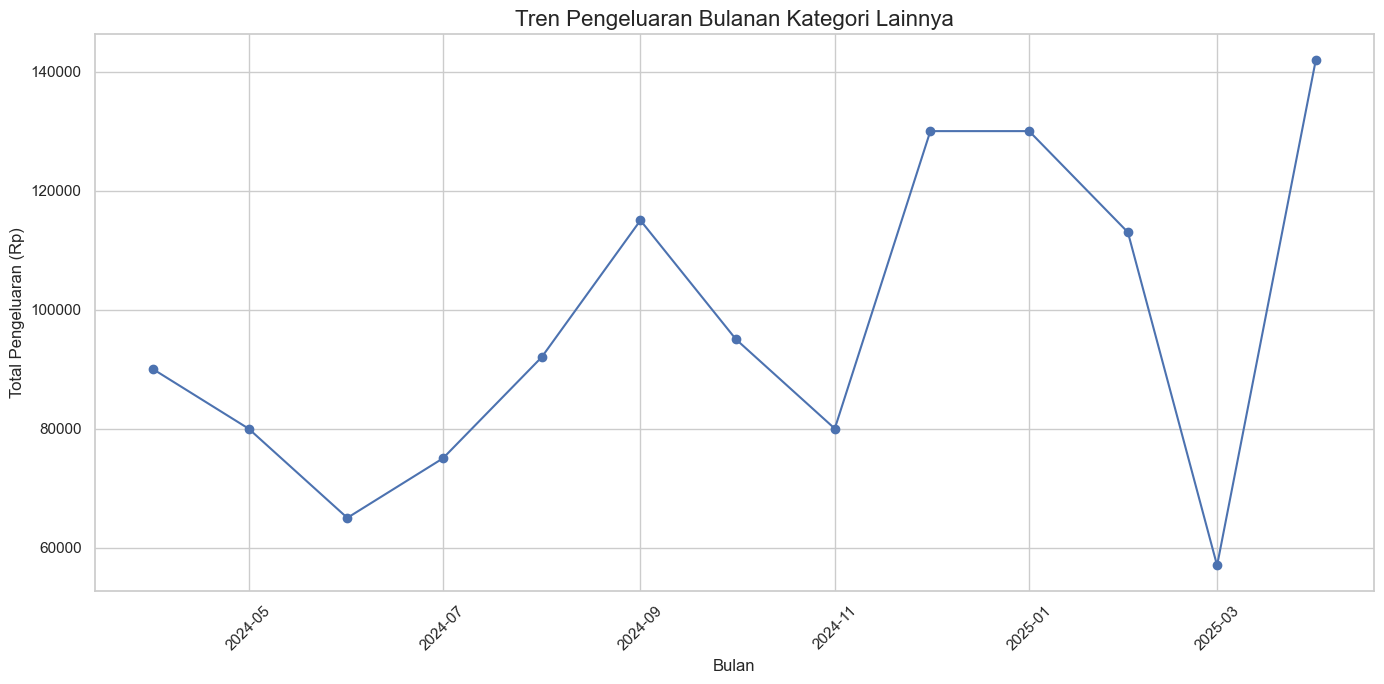

In [12]:
plot_kategori_tren(monthly_expenses, 'Lainnya')

# Splitting data

In [13]:
kategori = 'Lainnya'
data_kategori = monthly_expenses[kategori]

train = data_kategori[:-1]
test = data_kategori[-1:]

print("Train data:")
print(train.tail())
print("\nTest data:")
print(test)

Train data:
bulan
2024-11-01     80000.0
2024-12-01    130000.0
2025-01-01    130000.0
2025-02-01    113000.0
2025-03-01     57000.0
Name: Lainnya, dtype: float64

Test data:
bulan
2025-04-01    142000.0
Name: Lainnya, dtype: float64


# Modelling

In [14]:
results = {}

# ==== ARIMA ====
model_arima = ARIMA(train, order=(1,1,1))
fit_arima = model_arima.fit()
pred_train_arima = fit_arima.predict(start=train.index[1], end=train.index[-1])
pred_test_arima = fit_arima.forecast(steps=1)

rmse_train_arima = np.sqrt(mean_squared_error(train[1:], pred_train_arima))
rmse_test_arima = np.sqrt(mean_squared_error(test, pred_test_arima))

results['ARIMA'] = (rmse_train_arima, rmse_test_arima)

In [15]:
# ==== SARIMA ====
model_sarima = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12))
fit_sarima = model_sarima.fit(disp=False)
pred_train_sarima = fit_sarima.predict(start=train.index[1], end=train.index[-1])
pred_test_sarima = fit_sarima.forecast(steps=1)

rmse_train_sarima = np.sqrt(mean_squared_error(train[1:], pred_train_sarima))
rmse_test_sarima = np.sqrt(mean_squared_error(test, pred_test_sarima))

results['SARIMA'] = (rmse_train_sarima, rmse_test_sarima)

In [16]:
# ==== Simple Exponential Smoothing ====
model_ses = SimpleExpSmoothing(train)
fit_ses = model_ses.fit()
pred_train_ses = fit_ses.fittedvalues
pred_test_ses = fit_ses.forecast(1)

rmse_train_ses = np.sqrt(mean_squared_error(train, pred_train_ses))
rmse_test_ses = np.sqrt(mean_squared_error(test, pred_test_ses))

results['SES'] = (rmse_train_ses, rmse_test_ses)

In [17]:
# ==== Holt-Winters ====
model_hw = ExponentialSmoothing(train, trend='add', seasonal=None, seasonal_periods=3)
fit_hw = model_hw.fit()
pred_train_hw = fit_hw.fittedvalues
pred_test_hw = fit_hw.forecast(1)

rmse_train_hw = np.sqrt(mean_squared_error(train, pred_train_hw))
rmse_test_hw = np.sqrt(mean_squared_error(test, pred_test_hw))

results['Holt-Winters'] = (rmse_train_hw, rmse_test_hw)

In [18]:
# ==== Tampilkan hasil ====
print("RMSE per model (Train dan Test):\n")
for model_name, (rmse_train, rmse_test) in results.items():
    print(f"{model_name}: RMSE Train = {rmse_train:.2f}, RMSE Test = {rmse_test:.2f}")

RMSE per model (Train dan Test):

ARIMA: RMSE Train = 25912.90, RMSE Test = 75065.52
SARIMA: RMSE Train = 26616.81, RMSE Test = 39999.98
SES: RMSE Train = 23354.80, RMSE Test = 51788.32
Holt-Winters: RMSE Train = 25362.44, RMSE Test = 7762.83


# TUNING

In [19]:
best_model = None
best_rmse = float('inf')
best_params = {}

trend_options = ['add', 'mul', None]
seasonal_options = ['add', 'mul', None]
seasonal_periods_options = [3, 6, 12]

for trend in trend_options:
    for seasonal in seasonal_options:
        for sp in seasonal_periods_options:
            if seasonal is None and sp != 3:
                continue  # kalau tidak ada musiman, seasonal_periods tidak diperlukan

            try:
                model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=sp)
                fit = model.fit()
                pred = fit.forecast(1)
                rmse = np.sqrt(mean_squared_error(test, pred))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = fit
                    best_params = {
                        'trend': trend,
                        'seasonal': seasonal,
                        'seasonal_periods': sp
                    }

                print(f"Uji kombinasi trend={trend}, seasonal={seasonal}, seasonal_periods={sp} → RMSE: {rmse:.2f}")
            
            except:
                continue

print("\n Hasil Tuning Holt-Winters Terbaik:")
print(f"Parameter terbaik: {best_params}")
print(f"RMSE Test terbaik: {best_rmse:.2f}")

Uji kombinasi trend=add, seasonal=add, seasonal_periods=3 → RMSE: 13717.07
Uji kombinasi trend=add, seasonal=add, seasonal_periods=6 → RMSE: 32285.41
Uji kombinasi trend=add, seasonal=mul, seasonal_periods=3 → RMSE: 13978.60
Uji kombinasi trend=add, seasonal=mul, seasonal_periods=6 → RMSE: 33181.12
Uji kombinasi trend=add, seasonal=None, seasonal_periods=3 → RMSE: 7762.83
Uji kombinasi trend=mul, seasonal=add, seasonal_periods=3 → RMSE: 26419.46
Uji kombinasi trend=mul, seasonal=add, seasonal_periods=6 → RMSE: 151614.18
Uji kombinasi trend=mul, seasonal=mul, seasonal_periods=3 → RMSE: 26025.35
Uji kombinasi trend=mul, seasonal=mul, seasonal_periods=6 → RMSE: 123819.89
Uji kombinasi trend=mul, seasonal=None, seasonal_periods=3 → RMSE: 31028.61
Uji kombinasi trend=None, seasonal=add, seasonal_periods=3 → RMSE: 49552.27
Uji kombinasi trend=None, seasonal=add, seasonal_periods=6 → RMSE: 46949.09
Uji kombinasi trend=None, seasonal=mul, seasonal_periods=3 → RMSE: 1137.91
Uji kombinasi trend=

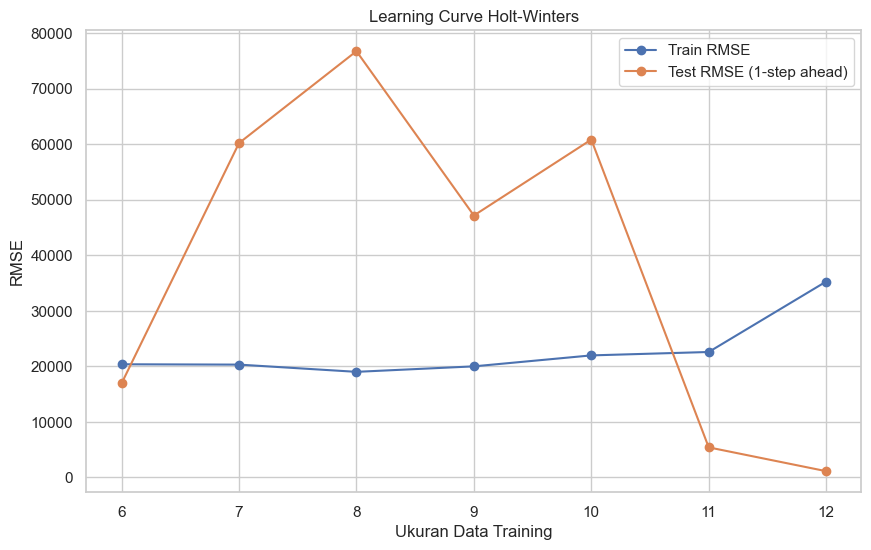

In [20]:
# Parameter terbaik dari tuning (hasil dari kode sebelumnya)
best_trend = best_params['trend']
best_seasonal = best_params['seasonal']
best_sp = best_params['seasonal_periods']

train_values = train.values
test_values = test.values

train_sizes = list(range(6, len(train_values) + 1))  # mulai dari 6 data sampai penuh
train_rmse_list = []
test_rmse_list = []

for size in train_sizes:
    train_subset = train_values[:size]
    test_point = test_values[0]  # test cuma 1 data (bulan terakhir)

    # Fit model Holt-Winters dengan parameter terbaik
    model = ExponentialSmoothing(train_subset, trend=best_trend, seasonal=best_seasonal, seasonal_periods=best_sp)
    fit = model.fit()

    # Prediksi pada data training (fitted values)
    train_pred = fit.fittedvalues
    train_rmse = np.sqrt(mean_squared_error(train_subset, train_pred))

    # Forecast 1-step ahead untuk test
    test_pred = fit.forecast(1)
    test_rmse = np.sqrt(mean_squared_error([test_point], test_pred))

    train_rmse_list.append(train_rmse)
    test_rmse_list.append(test_rmse)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse_list, marker='o', label='Train RMSE')
plt.plot(train_sizes, test_rmse_list, marker='o', label='Test RMSE (1-step ahead)')
plt.title('Learning Curve Holt-Winters')
plt.xlabel('Ukuran Data Training')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
pred_train_hw_best = best_model.fittedvalues
pred_test_hw_best = best_model.forecast(steps=1)

print("\nHasil Prediksi vs Aktual (Data Test):")
print(f"Tanggal: {test.index[0].strftime('%Y-%m')}")
print(f"Nilai Aktual: {test.values[0]:.2f}")
print(f"Nilai Prediksi: {pred_test_hw_best.values[0]:.2f}")
print(f"RMSE Test: {np.sqrt(mean_squared_error(test, pred_test_hw_best)):.2f}")


Hasil Prediksi vs Aktual (Data Test):
Tanggal: 2025-04
Nilai Aktual: 142000.00
Nilai Prediksi: 140862.09
RMSE Test: 1137.91


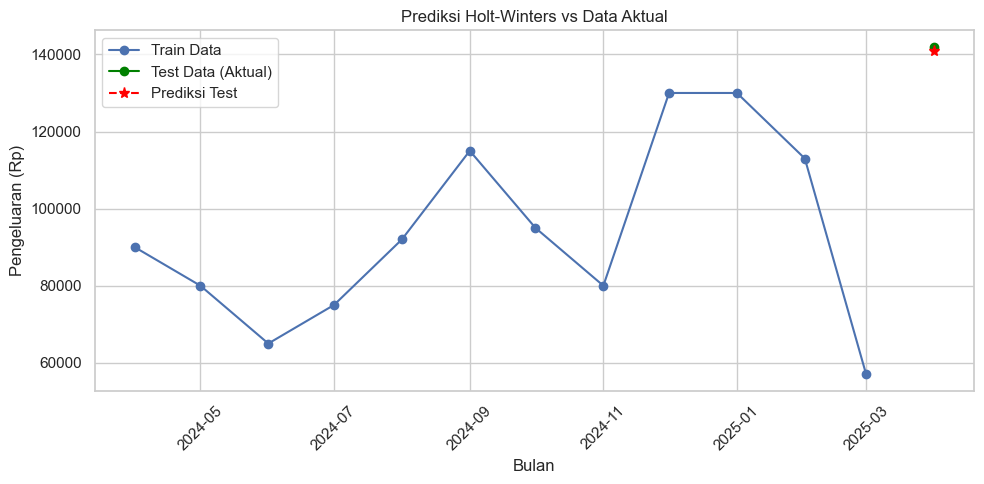

In [22]:
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train Data', marker='o')
plt.plot(test.index, test, label='Test Data (Aktual)', marker='o', color='green')
plt.plot(test.index, pred_test_hw_best, label='Prediksi Test', color='red', marker='*', linestyle='--', markersize=8)
plt.title('Prediksi Holt-Winters vs Data Aktual')
plt.xlabel('Bulan')
plt.ylabel('Pengeluaran (Rp)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
# Gunakan parameter terbaik dari hasil tuning sebelumnya
best_trend = best_params['trend']
best_seasonal = best_params['seasonal']
best_sp = best_params['seasonal_periods']

# Latih ulang model pada seluruh data
final_model = ExponentialSmoothing(
    data_kategori,
    trend=best_trend,
    seasonal=best_seasonal,
    seasonal_periods=best_sp
).fit()

# Prediksi 1 langkah ke depan (bulan berikutnya)
forecast_next_month = final_model.forecast(steps=1)

# Tampilkan hasil prediksi
print(" Prediksi Pengeluaran Bulan Selanjutnya:")
print(f"Tanggal prediksi: {forecast_next_month.index[0].strftime('%Y-%m')}")
print(f"Nilai prediksi: Rp {forecast_next_month.values[0]:,.2f}")


 Prediksi Pengeluaran Bulan Selanjutnya:
Tanggal prediksi: 2025-05
Nilai prediksi: Rp 103,110.07


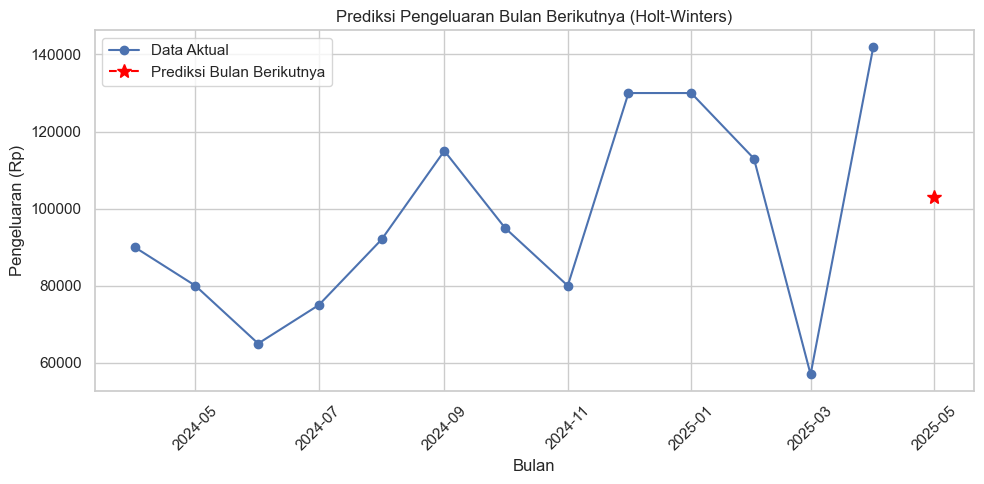

In [24]:
plt.figure(figsize=(10, 5))
plt.plot(data_kategori.index, data_kategori, label='Data Aktual', marker='o')
plt.plot(forecast_next_month.index, forecast_next_month, label='Prediksi Bulan Berikutnya', marker='*', linestyle='--', markersize=10, color='red')
plt.title('Prediksi Pengeluaran Bulan Berikutnya (Holt-Winters)')
plt.xlabel('Bulan')
plt.ylabel('Pengeluaran (Rp)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
import pickle

# Simpan model ke file
with open("Lainnya.pkl", "wb") as file:
    pickle.dump(final_model, file)

print("Model berhasil disimpan")

Model berhasil disimpan


In [26]:
# Muat kembali model dari file
with open("Lainnya.pkl", "rb") as file:
    loaded_hw_model = pickle.load(file)